## Research Task - Incorporate feedback to Transit Performance Metrics Portfolio #1514

via Juan Matute
>If you're taking requests, I'd like to see the Table 8.1 performance metrics on a statewide basis, along with a 
>- list for each performance metric of which individual transit agency-mode of service combinations are 
>- in the bottom 5% (approximately two standard deviations from the mean) for each. 
>
>This would be illustrative for discussion purposes.


## Table 8.1
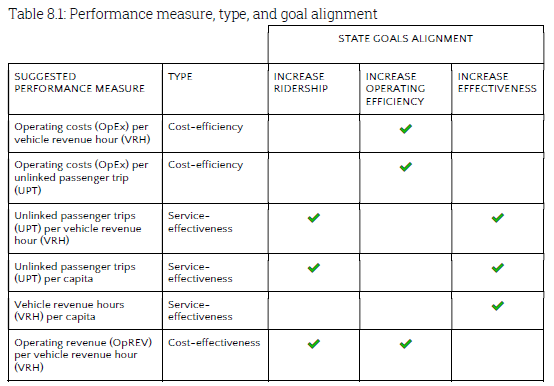

In [ ]:
import altair as alt
import numpy as np
import pandas as pd
from new_transit_metrics_utils import GCS_FILE_PATH, make_long, sum_by_group

alt.renderers.enable("html")

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [ ]:
# read in data
df = pd.read_parquet(f"{GCS_FILE_PATH}raw_transit_performance_metrics_data.parquet")

# aggregate by categories
df_agg = (
    df.groupby(["ntd_id", "city", "agency_name", "mode", "service"])
    .agg({"upt": "sum", "vrh": "sum", "vrm": "sum", "opexp_total": "sum"})
    .reset_index()
)

# set up dict for new columns loop
calc_dict = {
    "opex_per_vrh": ("opexp_total", "vrh"),
    "opex_per_vrm": ("opexp_total", "vrm"),
    "upt_per_vrh": ("upt", "vrh"),
    "upt_per_vrm": ("upt", "vrm"),
    "opex_per_upt": ("opexp_total", "upt"),
}

# loop to calculate performance metric and establih column name using dict
for new_col, (num, dem) in calc_dict.items():
    df_agg[new_col] = (df_agg[num] / df_agg[dem]).round(2)

In [ ]:
# calculated metrics resulted NaN and inf files!
# df_agg.describe()

## Dealing with `NaN` and `inf` values
Some of the metric calculation results in either `inf` or `NaN` values due to divide-by-zero scenarios. These values break the standard devatition calculation and visuals

Comparing removing rows with zero values vs. removing rows with inf/NaN values resulted in equivilent dataframes. 



In [ ]:
# 1. remove rows with zero values for each metric
no_zero_rows = df_agg[
    (df_agg["upt"] != 0)
    & (df_agg["vrh"] != 0)
    & (df_agg["vrm"] != 0)
    & (df_agg["opexp_total"] != 0)
]

# 3. What are the rows with zero values?
zero_rows = df_agg[
    (df_agg["upt"] == 0)
    | (df_agg["vrh"] == 0)
    | (df_agg["vrm"] == 0)
    | (df_agg["opexp_total"] == 0)
]


## Comparing initial aggregated dataframe to datafrom without zero values

In [ ]:
# display(
#     f"How many rows were removed from the initial dataframe? {len(df_agg)-len(no_zero_rows)}",
#     "Which agencies/rows were removed?",
#     zero_rows.sort_values(by="agency_name")
# )

### Conclusion
11 rows with either zero,inf,NaN values were identified. Both methods (filtering out zero-values and filtering out inf/NaN values) resulted in equivilent results.

Moving forward with `no_zero_rows` for the remainder of the analysis.

## Overall Summary Statistics

In [ ]:
all_metrics = [
    "upt_per_vrh",
    "upt_per_vrm",
    "opex_per_vrh",
    "opex_per_vrm",
    "opex_per_upt",
]

service_metrics_list= [
    "upt_per_vrh",
    "upt_per_vrm",
]

cost_metrics_list = [
    "opex_per_vrh",
    "opex_per_vrm",
    "opex_per_upt",
]

In [ ]:
no_zero_rows[all_metrics].describe()

In [ ]:
# melting dataframe for visuals
no_zero_rows_melt = pd.melt(
    no_zero_rows,
    id_vars=["ntd_id", "city", "agency_name", "mode", "service"],
    value_vars=[
        "opex_per_vrh",
        "opex_per_vrm",
        "upt_per_vrh",
        "upt_per_vrm",
        "opex_per_upt",
    ],
    var_name="performance_metrics",
    value_name="metric_units",
)


In [ ]:
def metrics_charts(metrics_list: list, df: pd.DataFrame):
    """Function produces 3 charts: Box plot, bar chart, histogram.
    Takes in a dataframe and loops through a list of performance metrics.
    """
    selection = alt.selection_point(fields=['service'], bind='legend')
    
    for i in metrics_list:
        # box plot
        box_plot = (
            alt.Chart(df[df["performance_metrics"] == i])
            .mark_boxplot(extent="min-max")
            .encode(y="mode:N", x="metric_units:Q")
            .properties(
                title=f"Box Plot for {i}",
                width="container",
                height=300,
            )
        ).interactive()

        # bar chart
        bar_chart = (
            alt.Chart(df[df["performance_metrics"] == i])
            .mark_bar()
            .encode(
                x=alt.X("agency_name:N", sort="-y"),
                y=alt.Y("metric_units:Q", title=i),
                color="service:N",
                tooltip=[
                    "agency_name:N", 
                    "mode:N", 
                    "service:N", 
                    "metric_units:Q",
                ],
                opacity=alt.when(selection).then(alt.value(0.8)).otherwise(alt.value(0.2)),
            )
            .properties(
                width=400,
                height=200,
            )
            .facet("mode:N", columns=3, title=f"Barchart For All {i}")
            .resolve_scale(x="independent", y="independent")
            .add_params(
                selection
            )
        )
        
        # distribution plot
        histogram = (
            alt.Chart(df[df["performance_metrics"] == i])
            .mark_bar()
            .encode(
                alt.X("metric_units:Q",
                      bin=alt.Bin(step=5),
                      # bin=True),
                     ).bin(maxbins=100),
                y="count()",
                tooltip=[
                    "count()",
                    alt.Tooltip('metric_units:Q', bin=alt.Bin(step=5), title=f'bin range for {i}')
                ],
            )
            .properties(
                title=f"{i} Distribution",
                width=500,  # smaller width per facet
                height=200,
            )
            .facet("mode:N", columns=3)
            .resolve_scale(x="independent", y="independent")
        ).interactive()


        display(
            f"Box plot for {i}",
            box_plot,
            f"Statewide Bar Chart for {i}",
            bar_chart,
            f"Histogram Chart for {i}",
            histogram,
        )

## Statewide Service-Effectiveness Metrics

### Unlinked Passenger Trips per Vehicle Revenue Hours
upt_per_vrh

In [ ]:
metrics_charts(metrics_list=["upt_per_vrh"], df=no_zero_rows_melt)

### Unlinked Passenger Trips by Vehicle Revenue Miles
upt_per_vrm

In [ ]:
metrics_charts(metrics_list=["upt_per_vrm"], df=no_zero_rows_melt)

## Statewide Cost-Effecticeness Metrics

### Operating Expense per Vehicle Revenue Hours
opex_per_vrh

In [ ]:
metrics_charts(["opex_per_vrh"], df=no_zero_rows_melt)

### Operating Expense per Vehicle Revenue Miles
opex_per_vrm

In [ ]:
metrics_charts(["opex_per_vrm"], df=no_zero_rows_melt)

### Operating Expense per Unlinked Passenger Trips
opex_per_upt

In [ ]:
metrics_charts(["opex_per_upt"], df=no_zero_rows_melt)

## Bottom 5% of Performance Metrics


### Bottom 5% Service-Effectiveness Metrics

In [ ]:
## SPLIT other chart test
# Who are the bottom 5% of each performance metrics

for metric_name in service_metrics_list:
    service_cutoff = no_zero_rows[metric_name].quantile(0.05)
    service_bottom = no_zero_rows[no_zero_rows[metric_name] <= service_cutoff][
        ["agency_name", "mode", "service", metric_name]
    ]
    selection = alt.selection_point(fields=['service'], bind='legend')
    
    display(
        print(f"""Service-effectivness: Bottom 5% of {metric_name}
        """),
        
        alt.Chart(service_bottom).mark_bar().encode(
            x=alt.X("agency_name:N", sort="y"),
            xOffset="mode:N",
            color="service:N",
            y=alt.Y(metric_name, stack=None),
            tooltip=["agency_name", "mode", metric_name],
            opacity=alt.when(selection).then(alt.value(0.8)).otherwise(alt.value(0.2))
        ).properties(title=f"Bottom 5% {metric_name}", width="container").add_params(selection),
        service_bottom.sort_values(by=metric_name, ascending=True),
                )

### Bottom 5% Cost-Effectiveness Metrics

In [ ]:
for metric_name in cost_metrics_list:
    cost_cutoff = no_zero_rows[metric_name].quantile(0.95)
    cost_bottom = no_zero_rows[no_zero_rows[metric_name] >= cost_cutoff][
        ["agency_name", "mode", "service", metric_name]
    ]
    
    selection = alt.selection_point(fields=['service'], bind='legend')
    
    display(
        print(f"""Cost-effectivness:Bottom 5% of {metric_name}
        """),
        alt.Chart(cost_bottom).mark_bar().encode(
            x=alt.X("agency_name:N", sort="-y"),
            xOffset= alt.XOffset("mode:N", sort="-y"),
            color="service:N",
            y=alt.Y(metric_name, 
                    # stack=None
                    ),
            tooltip=["agency_name", "mode", metric_name],
            opacity=alt.when(selection).then(alt.value(0.8)).otherwise(alt.value(0.2))
        ).properties(title=f"Bottom 5% {metric_name}", width="container").add_params(selection),
        
        cost_bottom.sort_values(by=metric_name, ascending=False)
    )

---